In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

##**1 Assignment: CIFAR-10 Classification**

### **1.1 Prepare the Dataset**

In [3]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL9OWQO/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteL9OWQO/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# preprocessing pipeline

def prepare_cifar10(cifar10):
  # change data type
  cifar10 = cifar10.map(lambda img, target: (tf.cast(img, tf.float32), target))
  # normalisation
  cifar10 = cifar10.map(lambda img, target: ((img/128.)-1., target))
  # on hot encoding
  cifar10 = cifar10.map(lambda img, target: (img, tf.one_hot(indices=target, depth=10)))
  # cache
  cifar10.cache()
  # shuffle batch prefetch
  cifar10 = cifar10.shuffle(1000)
  cifar10 = cifar10.batch(32)
  cifar10 = cifar10.prefetch(20)

  return cifar10

# apply preprocessing
train_dataset = train_ds.apply(prepare_cifar10)
test_dataset = test_ds.apply(prepare_cifar10)

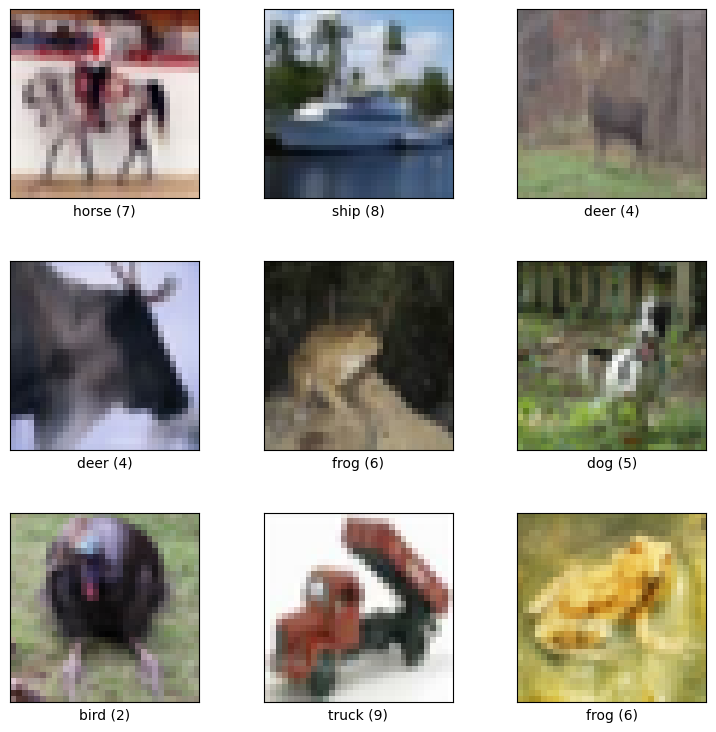

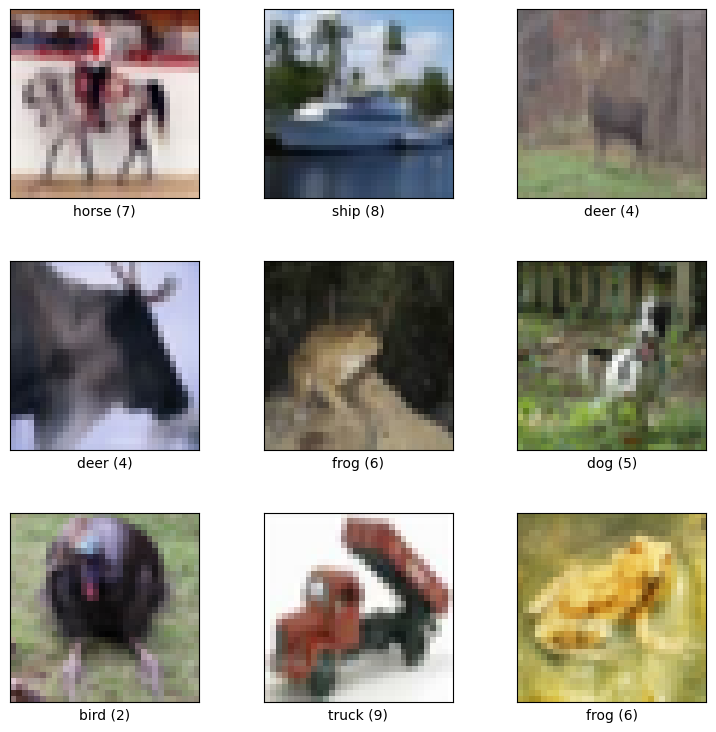

In [ ]:
tfds.show_examples(train_ds , info_ds)

### **1.2 The CNN Model**

In [5]:
class CNNModel(tf.keras.Model):

  def __init__(self):
    super(CNNModel, self).__init__()

    # model architecture
    self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, x):
      x = self.convlayer1(x)
      x = self.convlayer2(x)
      x = self.pooling(x)
      x = self.convlayer3(x)
      x = self.convlayer4(x)
      x = self.global_pool(x)
      x = self.out(x)
      return x

In [12]:
class CNNModel2(tf.keras.Model):

  def __init__(self):
    super(CNNModel2, self).__init__()

    # model architecture
    self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer6 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, x):
      x = self.convlayer1(x)
      x = self.convlayer2(x)
      x = self.convlayer3(x)
      x = self.pooling(x)
      x = self.convlayer4(x)
      x = self.convlayer5(x)
      x = self.convlayer6(x)
      x = self.global_pool(x)
      x = self.out(x)
      return x

### **1.3 Training the network**

In [7]:
def train_loop(model, train_ds, test_ds, loss_func, optimizer, num_epochs=10):

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  for epoch in range(num_epochs):


    #training
    epoch_losses = []
    epoch_accuracies = []
    for input,target in train_ds:
        loss, accuracy = train_step(model, input, target, loss_func, optimizer)
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    #track training loss and accuracies
    train_losses.append(tf.reduce_mean(epoch_losses))
    train_accuracies.append(tf.reduce_mean(epoch_accuracies))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test_loop(model, test_ds, loss_func)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f' After epoch {str(epoch+1)} the accuracy is: {test_accuracies[-1]}')

  return train_losses, train_accuracies, test_losses, test_accuracies

def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

def test_loop(model, test_ds, loss_func):
  test_accuracy_agg = []
  test_loss_agg = []

  for (input, target) in test_ds:
    prediction = model(input)
    sample_test_loss = loss_func(target, prediction)
    # sample_test_accuracy hat boolean pro sample in batch (länge ist also wie batch size)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # mean accuracy for the batch
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_agg.append(sample_test_loss.numpy())
    test_accuracy_agg.append(sample_test_accuracy)


  test_loss = tf.reduce_mean(test_loss_agg)
  test_accuracy = tf.reduce_mean(test_accuracy_agg)

  return test_loss, test_accuracy


In [ ]:
cifar10Model = CNNModel()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 15

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.4719448881789137
 After epoch 2 the accuracy is: 0.5420327476038339
 After epoch 3 the accuracy is: 0.5921525559105432
 After epoch 4 the accuracy is: 0.5838658146964856
 After epoch 5 the accuracy is: 0.6458666134185304
 After epoch 6 the accuracy is: 0.6252995207667732
 After epoch 7 the accuracy is: 0.637979233226837
 After epoch 8 the accuracy is: 0.6733226837060703
 After epoch 9 the accuracy is: 0.6940894568690096
 After epoch 10 the accuracy is: 0.6935902555910544
 After epoch 11 the accuracy is: 0.6816094249201278
 After epoch 12 the accuracy is: 0.7067691693290735
 After epoch 13 the accuracy is: 0.7149560702875399
 After epoch 14 the accuracy is: 0.739117412140575
 After epoch 15 the accuracy is: 0.7302316293929713


### **1.4 Visualization**

In [8]:

def visualization( train_losses , train_accuracies , test_losses , test_accuracies):


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))


  # Plot the Loss
  ax1.plot(train_losses, color="purple", label="Train")
  ax1.plot(test_losses, color="skyblue", label="Test")
  ax1.set_title("Train vs. Test Loss")
  ax1.legend()
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  #ax1.show()

  # Plot the Accuracy
  ax2.plot(train_accuracies, color="purple", label="Train")
  ax2.plot(test_accuracies, color="skyblue", label="Test")
  ax2.set_title("Train vs. Test Accuracy")
  ax2.legend()
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  plt.show()

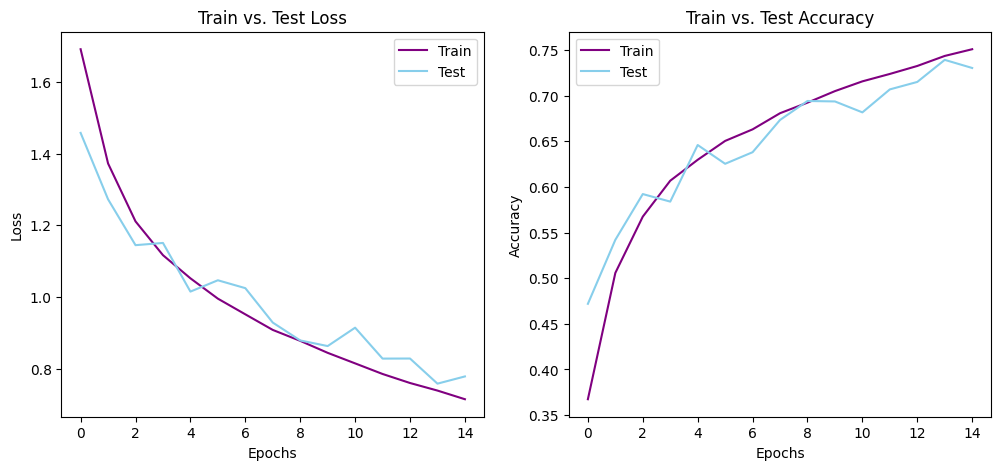

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## **2 Adjust hyperparameters and architecture**

1. base configuration

In [ ]:
cifar10Model = CNNModel()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 15

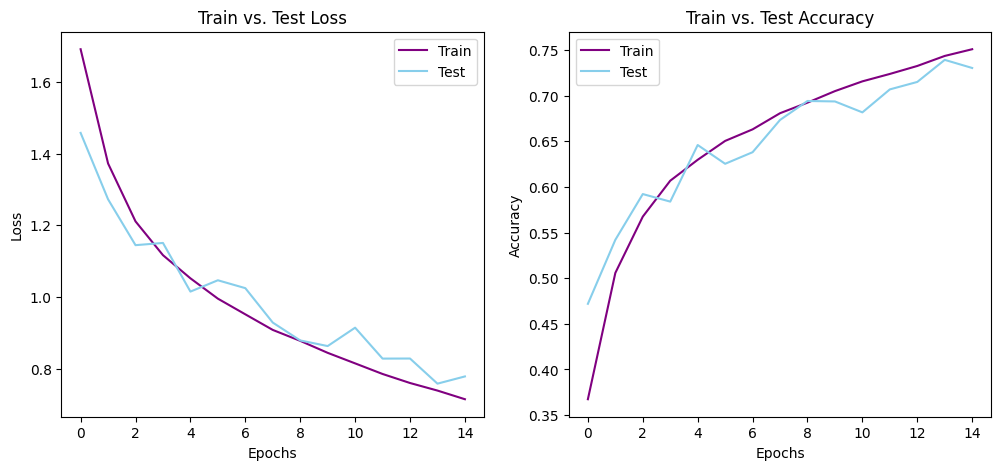

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

2. different learning rate

In [ ]:
cifar10Model = CNNModel()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.3240814696485623
 After epoch 2 the accuracy is: 0.4387979233226837
 After epoch 3 the accuracy is: 0.45756789137380194
 After epoch 4 the accuracy is: 0.4617611821086262
 After epoch 5 the accuracy is: 0.4601637380191693
 After epoch 6 the accuracy is: 0.48113019169329074
 After epoch 7 the accuracy is: 0.5088857827476039
 After epoch 8 the accuracy is: 0.49331070287539935
 After epoch 9 the accuracy is: 0.5022963258785943
 After epoch 10 the accuracy is: 0.5041932907348243
 After epoch 11 the accuracy is: 0.5023961661341853
 After epoch 12 the accuracy is: 0.4965055910543131
 After epoch 13 the accuracy is: 0.49241214057507987
 After epoch 14 the accuracy is: 0.49460862619808305
 After epoch 15 the accuracy is: 0.5168730031948882


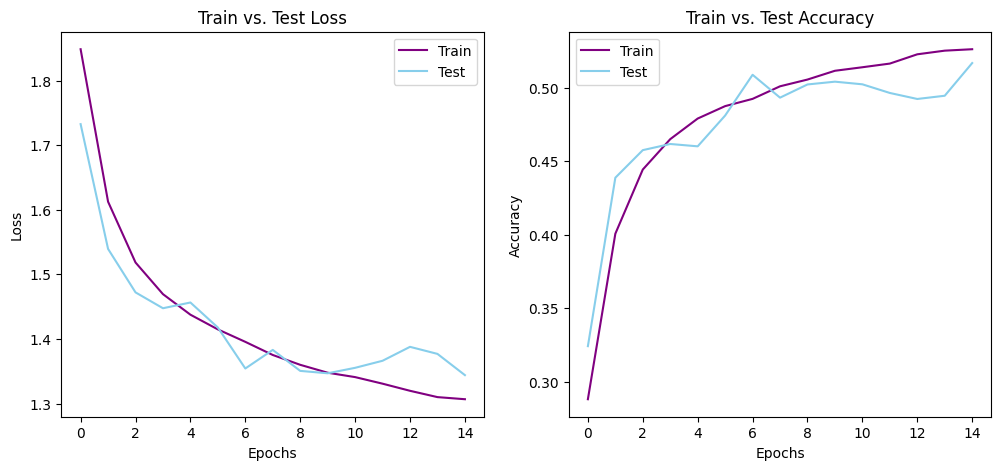

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

3. different optimizer

In [ ]:
cifar10Model = CNNModel()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.14406948881789136
 After epoch 2 the accuracy is: 0.14456869009584664
 After epoch 3 the accuracy is: 0.14217252396166133
 After epoch 4 the accuracy is: 0.15485223642172524
 After epoch 5 the accuracy is: 0.192991214057508
 After epoch 6 the accuracy is: 0.2139576677316294
 After epoch 7 the accuracy is: 0.2209464856230032
 After epoch 8 the accuracy is: 0.23123003194888178
 After epoch 9 the accuracy is: 0.23732028753993611
 After epoch 10 the accuracy is: 0.24181309904153356
 After epoch 11 the accuracy is: 0.2474041533546326
 After epoch 12 the accuracy is: 0.2549920127795527
 After epoch 13 the accuracy is: 0.26517571884984026
 After epoch 14 the accuracy is: 0.2759584664536741
 After epoch 15 the accuracy is: 0.2939297124600639


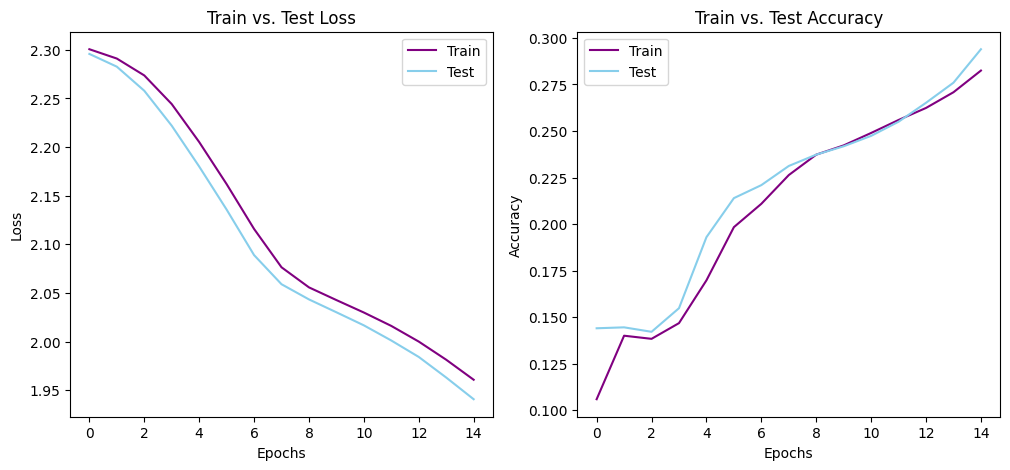

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

4. different opitmizer and learning rate

In [9]:
cifar10Model = CNNModel()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.2596845047923323
 After epoch 2 the accuracy is: 0.3185902555910543
 After epoch 3 the accuracy is: 0.3303714057507987
 After epoch 4 the accuracy is: 0.3660143769968051
 After epoch 5 the accuracy is: 0.3745007987220447
 After epoch 6 the accuracy is: 0.3802915335463259
 After epoch 7 the accuracy is: 0.4057507987220447
 After epoch 8 the accuracy is: 0.476138178913738
 After epoch 9 the accuracy is: 0.4702476038338658
 After epoch 10 the accuracy is: 0.4915135782747604
 After epoch 11 the accuracy is: 0.4947084664536741
 After epoch 12 the accuracy is: 0.5077875399361023
 After epoch 13 the accuracy is: 0.5198682108626198
 After epoch 14 the accuracy is: 0.5562100638977636
 After epoch 15 the accuracy is: 0.5403354632587859


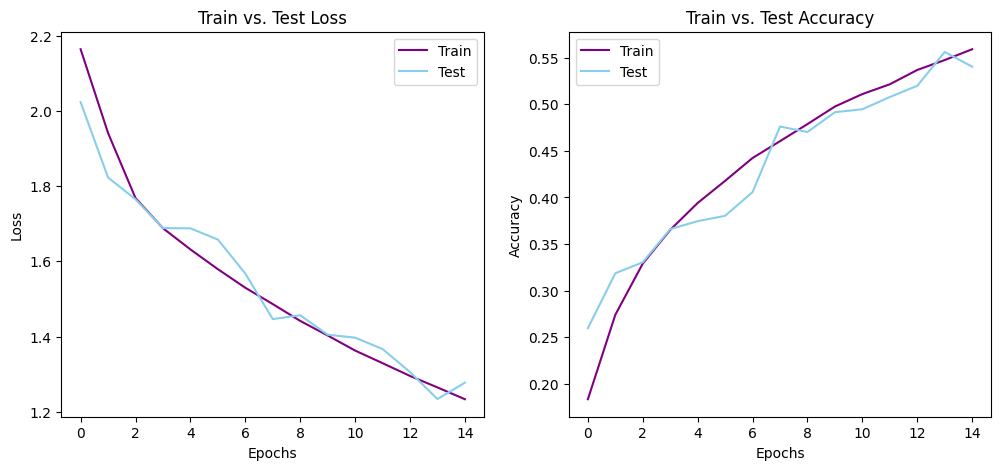

In [10]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

5. different architecture

In [14]:
cifar10Model = CNNModel2()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.48562300319488816
 After epoch 2 the accuracy is: 0.578973642172524
 After epoch 3 the accuracy is: 0.6338857827476039
 After epoch 4 the accuracy is: 0.6555511182108626
 After epoch 5 the accuracy is: 0.6763178913738019
 After epoch 6 the accuracy is: 0.6923921725239617
 After epoch 7 the accuracy is: 0.707667731629393
 After epoch 8 the accuracy is: 0.7199480830670927
 After epoch 9 the accuracy is: 0.7278354632587859
 After epoch 10 the accuracy is: 0.7449081469648562
 After epoch 11 the accuracy is: 0.7268370607028753
 After epoch 12 the accuracy is: 0.7576876996805112
 After epoch 13 the accuracy is: 0.7617811501597445
 After epoch 14 the accuracy is: 0.7651757188498403
 After epoch 15 the accuracy is: 0.7699680511182109


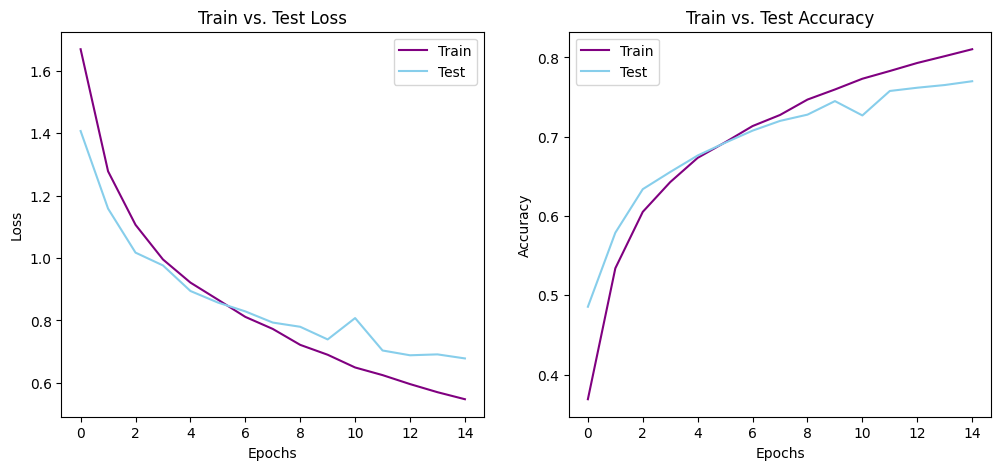

In [15]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

6. different architecture and learning rate

In [16]:
cifar10Model = CNNModel2()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.3072084664536741
 After epoch 2 the accuracy is: 0.38338658146964855
 After epoch 3 the accuracy is: 0.4077476038338658
 After epoch 4 the accuracy is: 0.4305111821086262
 After epoch 5 the accuracy is: 0.4387979233226837
 After epoch 6 the accuracy is: 0.4564696485623003
 After epoch 7 the accuracy is: 0.46884984025559107
 After epoch 8 the accuracy is: 0.45756789137380194
 After epoch 9 the accuracy is: 0.4759384984025559
 After epoch 10 the accuracy is: 0.4617611821086262
 After epoch 11 the accuracy is: 0.45397364217252395
 After epoch 12 the accuracy is: 0.45756789137380194
 After epoch 13 the accuracy is: 0.47503993610223644
 After epoch 14 the accuracy is: 0.4703474440894569
 After epoch 15 the accuracy is: 0.48791932907348246


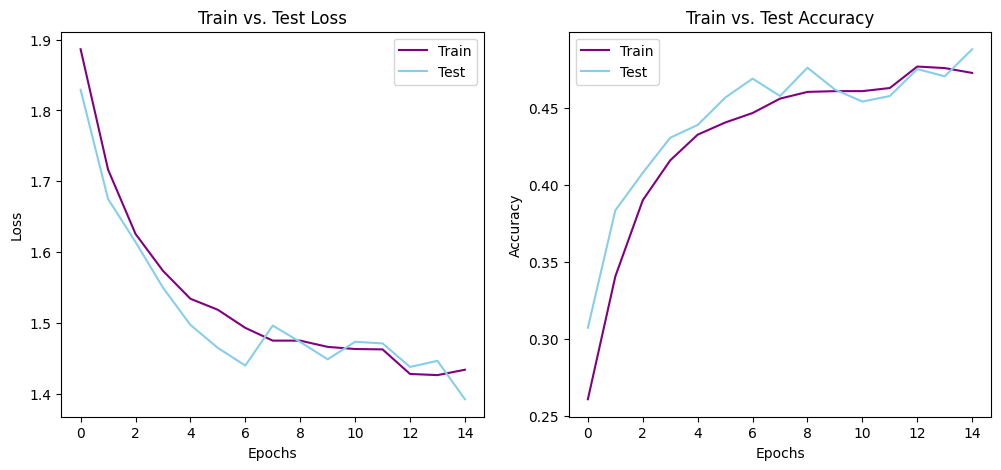

In [17]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

7. different architecture and optimizer

In [18]:
cifar10Model = CNNModel2()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.10163738019169329
 After epoch 2 the accuracy is: 0.10353434504792332
 After epoch 3 the accuracy is: 0.11731230031948882
 After epoch 4 the accuracy is: 0.13099041533546327
 After epoch 5 the accuracy is: 0.1558506389776358
 After epoch 6 the accuracy is: 0.20327476038338657
 After epoch 7 the accuracy is: 0.23592252396166133
 After epoch 8 the accuracy is: 0.27016773162939295
 After epoch 9 the accuracy is: 0.2800519169329074
 After epoch 10 the accuracy is: 0.264676517571885
 After epoch 11 the accuracy is: 0.29273162939297126
 After epoch 12 the accuracy is: 0.30860623003194887
 After epoch 13 the accuracy is: 0.32567891373801916
 After epoch 14 the accuracy is: 0.33256789137380194
 After epoch 15 the accuracy is: 0.3481429712460064


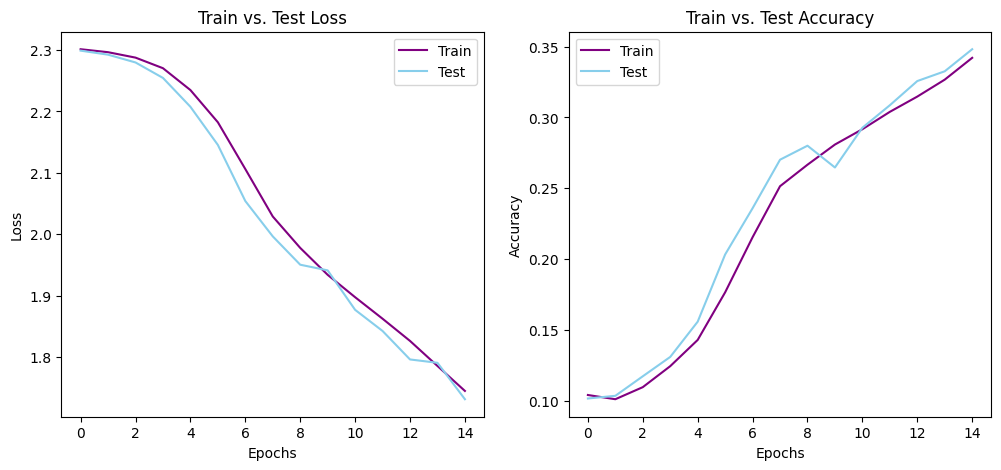

In [19]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

8. different architecture, optimizer and learning rate

In [20]:
cifar10Model = CNNModel2()

loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate)
num_epochs = 15
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(cifar10Model, train_dataset, test_dataset, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.2240415335463259
 After epoch 2 the accuracy is: 0.2762579872204473
 After epoch 3 the accuracy is: 0.32288338658146964
 After epoch 4 the accuracy is: 0.3726038338658147
 After epoch 5 the accuracy is: 0.39277156549520764
 After epoch 6 the accuracy is: 0.41613418530351437
 After epoch 7 the accuracy is: 0.3992611821086262
 After epoch 8 the accuracy is: 0.4584664536741214
 After epoch 9 the accuracy is: 0.49211261980830673
 After epoch 10 the accuracy is: 0.47304313099041534
 After epoch 11 the accuracy is: 0.4857228434504792
 After epoch 12 the accuracy is: 0.5446285942492013
 After epoch 13 the accuracy is: 0.4950079872204473
 After epoch 14 the accuracy is: 0.5557108626198083
 After epoch 15 the accuracy is: 0.5660942492012779


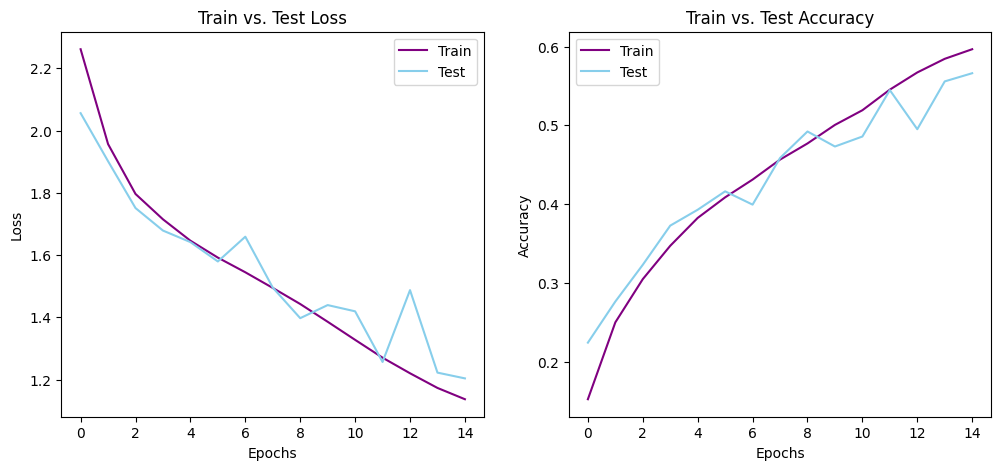

In [21]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)